[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!



Reading CSV files...
Successfully read 993 records from the first file
Successfully read 1459 records from the second file

Merging the two datasets...
Successfully merged 2452 records


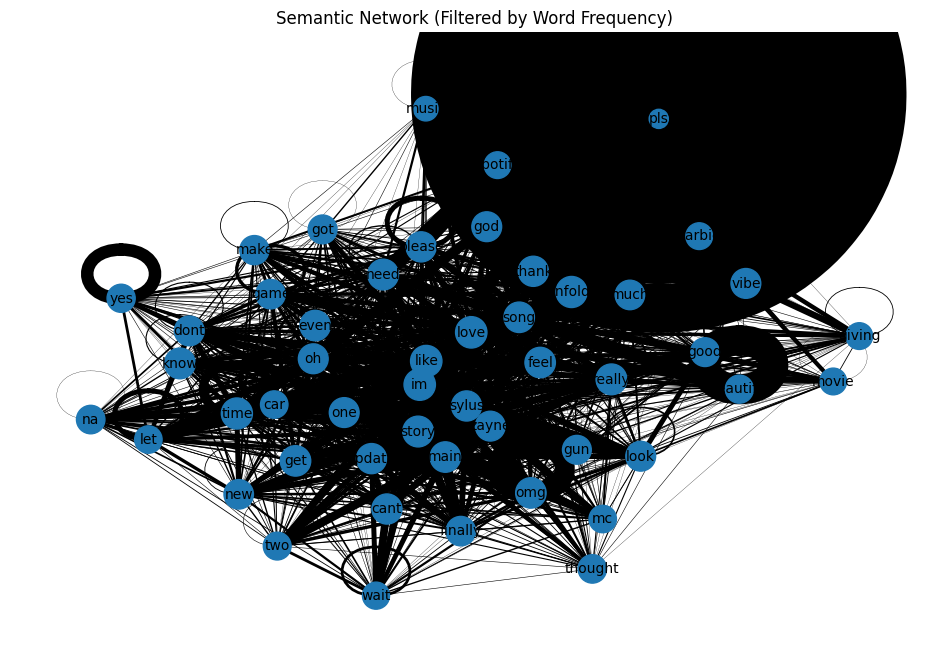

Top 10 nodes by degree (filtered):
love: 51
like: 51
im: 51
infold: 50
time: 50
need: 49
really: 49
story: 49
know: 49
song: 48
Network density (filtered): 0.9004081632653061


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from datetime import datetime, timedelta
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string
import networkx as nx  # 用于构建语义网络

# 下载必要的nltk数据
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

# Read CSV files
print("\nReading CSV files...")
try:
    # Read the first CSV file
    file1_path = '/content/dataset_youtube-comments-scraper_2025-06-17_06-57-22-932.csv'
    df1 = pd.read_csv(file1_path)
    print(f"Successfully read {len(df1)} records from the first file")

    # Read the second CSV file
    file2_path = '/content/dataset_youtube-comments-scraper_2025-06-17_07-02-35-990.csv'  # Replace with your second file path
    df2 = pd.read_csv(file2_path)
    print(f"Successfully read {len(df2)} records from the second file")

except FileNotFoundError as e:
    print(f"Error: File not found - {e.filename}")
    print("Please ensure the CSV file exists in the specified directory")
    exit()

# Merge the two DataFrames
print("\nMerging the two datasets...")
data = pd.concat([df1, df2], ignore_index=True)
print(f"Successfully merged {len(data)} records")

def preprocess_text(text):
    # 移除URL
    text = re.sub(r'http\S+', '', text)

    # 移除特殊字符和表情符号
    text = re.sub(r'[^\w\s]', '', text)

    # 转换为小写
    text = text.lower()

    # 过滤非英文字符
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # 分词
    tokens = word_tokenize(text)

    # 移除停用词
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    # 词形还原
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # 移除单个字符
    tokens = [word for word in tokens if len(word) > 1]

    return ' '.join(tokens)

# 处理发布时间
def convert_time(text):
    now = datetime.now()
    if 'day' in text:
        days = int(re.search(r'\d+', text).group())
        return now - timedelta(days=days)
    elif 'week' in text:
        weeks = int(re.search(r'\d+', text).group())
        return now - timedelta(weeks=weeks)
    else:
        return now  # 默认返回当前时间

# 应用预处理
data['processed_comment'] = data['comment'].apply(preprocess_text)
data['date'] = data['publishedTimeText'].apply(convert_time)
data['week'] = data['date'].apply(lambda x: x.isocalendar()[1])  # 提取周数

# 构建语义网络：基于词汇共现（这里以单个评论内词汇共现为基础，也可根据窗口大小调整）
def build_semantic_network(text_series):
    G = nx.Graph()
    for comment in text_series:
        words = comment.split()
        # 遍历评论中的词汇，构建共现关系
        for i in range(len(words)):
            for j in range(i + 1, len(words)):
                word1 = words[i]
                word2 = words[j]
                if G.has_edge(word1, word2):
                    G[word1][word2]['weight'] += 1
                else:
                    G.add_edge(word1, word2, weight=1)
    return G

# 统计词频
from collections import Counter

# 计算所有评论中每个词的出现次数
word_freq = Counter()
for comment in data['processed_comment']:
    word_freq.update(comment.split())

# 设置词频阈值（可根据需要调整）
MIN_FREQ = 40  # 只保留出现至少5次的词

# 过滤低频词
filtered_comments = []
for comment in data['processed_comment']:
    words = comment.split()
    filtered_words = [word for word in words if word_freq[word] >= MIN_FREQ]
    filtered_comments.append(' '.join(filtered_words))

# 使用过滤后的评论构建语义网络
semantic_network = build_semantic_network(filtered_comments)

# 可视化与分析代码保持不变
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(semantic_network, k=0.3)
nx.draw_networkx_nodes(semantic_network, pos, node_size=[v * 10 for v in dict(semantic_network.degree).values()])
nx.draw_networkx_edges(semantic_network, pos, width=[d['weight'] / 5 for (u, v, d) in semantic_network.edges(data=True)])
nx.draw_networkx_labels(semantic_network, pos, font_size=10)
plt.title("Semantic Network (Filtered by Word Frequency)")
plt.axis('off')
plt.show()

# 统计分析
degree_dict = dict(semantic_network.degree())
print("Top 10 nodes by degree (filtered):")
sorted_degree = sorted(degree_dict.items(), key=lambda x: x[1], reverse=True)[:10]
for word, degree in sorted_degree:
    print(f"{word}: {degree}")

network_density = nx.density(semantic_network)
print(f"Network density (filtered): {network_density}")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!



Reading CSV files...
Successfully read 993 records from the first file
Successfully read 1459 records from the second file

Merging the two datasets...
Successfully merged 2452 records


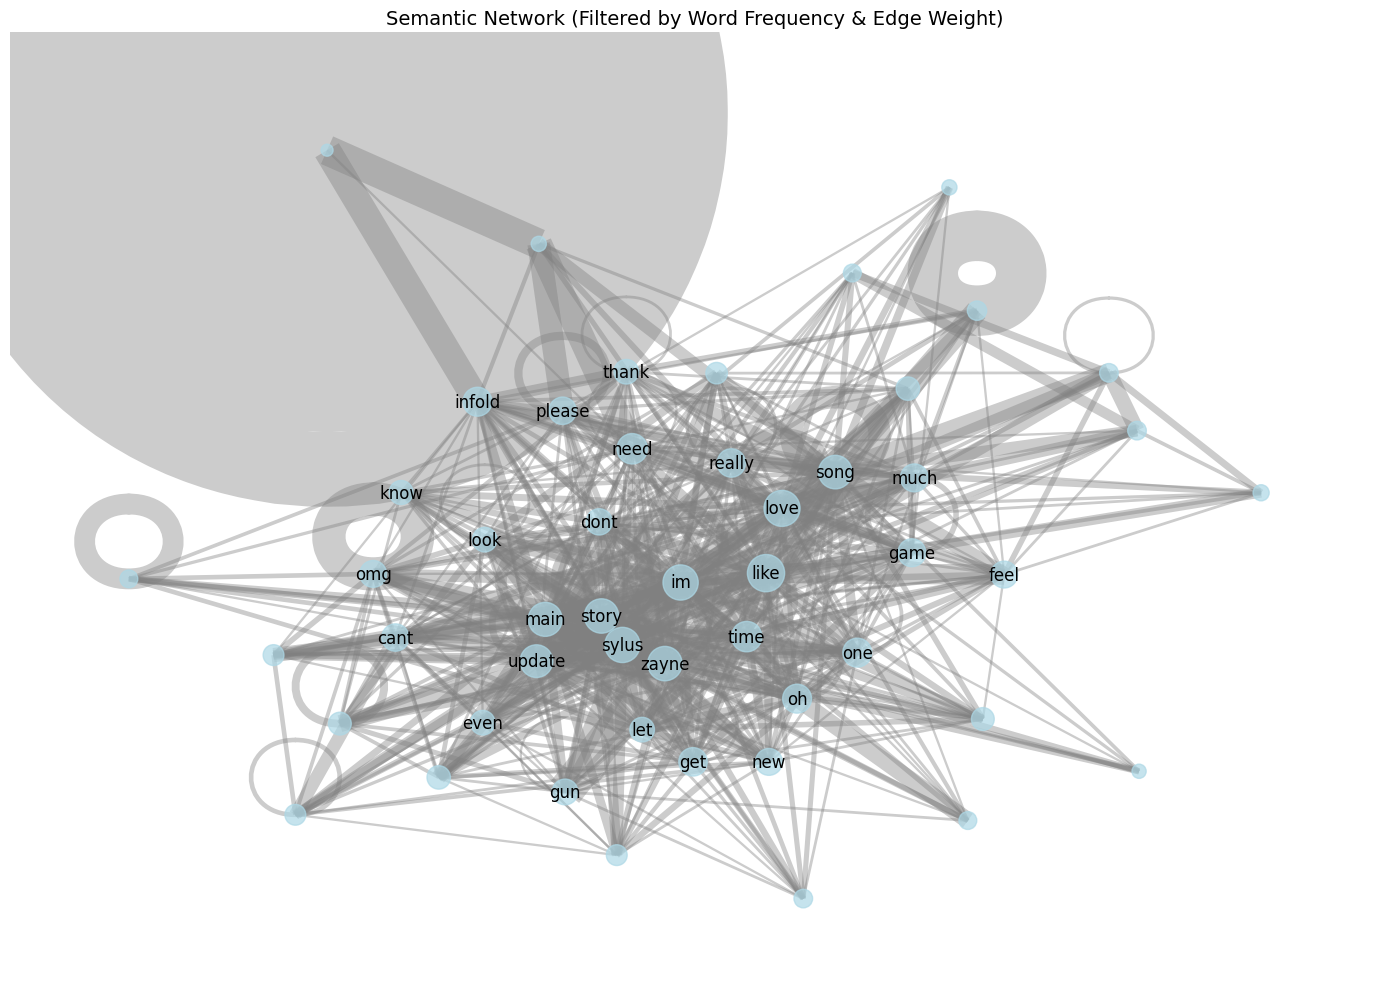

Top 10 nodes by degree (filtered):
like: 48
love: 45
sylus: 43
im: 43
zayne: 41
story: 41
main: 40
song: 39
update: 37
need: 32
Network density (filtered): 0.4776


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from datetime import datetime, timedelta
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string
import networkx as nx  # 用于构建语义网络

# 下载必要的nltk数据
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

# Read CSV files
print("\nReading CSV files...")
try:
    # Read the first CSV file
    file1_path = '/content/dataset_youtube-comments-scraper_2025-06-17_06-57-22-932.csv'
    df1 = pd.read_csv(file1_path)
    print(f"Successfully read {len(df1)} records from the first file")

    # Read the second CSV file
    file2_path = '/content/dataset_youtube-comments-scraper_2025-06-17_07-02-35-990.csv'  # Replace with your second file path
    df2 = pd.read_csv(file2_path)
    print(f"Successfully read {len(df2)} records from the second file")

except FileNotFoundError as e:
    print(f"Error: File not found - {e.filename}")
    print("Please ensure the CSV file exists in the specified directory")
    exit()

# Merge the two DataFrames
print("\nMerging the two datasets...")
data = pd.concat([df1, df2], ignore_index=True)
print(f"Successfully merged {len(data)} records")

def preprocess_text(text):
    # 移除URL
    text = re.sub(r'http\S+', '', text)

    # 移除特殊字符和表情符号
    text = re.sub(r'[^\w\s]', '', text)

    # 转换为小写
    text = text.lower()

    # 过滤非英文字符
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # 分词
    tokens = word_tokenize(text)

    # 移除停用词
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    # 词形还原
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # 移除单个字符
    tokens = [word for word in tokens if len(word) > 1]

    return ' '.join(tokens)

# 处理发布时间
def convert_time(text):
    now = datetime.now()
    if 'day' in text:
        days = int(re.search(r'\d+', text).group())
        return now - timedelta(days=days)
    elif 'week' in text:
        weeks = int(re.search(r'\d+', text).group())
        return now - timedelta(weeks=weeks)
    else:
        return now  # 默认返回当前时间

# 应用预处理
data['processed_comment'] = data['comment'].apply(preprocess_text)
data['date'] = data['publishedTimeText'].apply(convert_time)
data['week'] = data['date'].apply(lambda x: x.isocalendar()[1])  # 提取周数

# 构建语义网络：基于词汇共现
def build_semantic_network(text_series):
    G = nx.Graph()
    for comment in text_series:
        words = comment.split()
        for i in range(len(words)):
            for j in range(i + 1, len(words)):
                word1 = words[i]
                word2 = words[j]
                if G.has_edge(word1, word2):
                    G[word1][word2]['weight'] += 1
                else:
                    G.add_edge(word1, word2, weight=1)
    return G

# 统计词频并过滤低频词
from collections import Counter

word_freq = Counter()
for comment in data['processed_comment']:
    word_freq.update(comment.split())

MIN_FREQ = 40  # 词频阈值
filtered_comments = []
for comment in data['processed_comment']:
    words = comment.split()
    filtered_words = [word for word in words if word_freq[word] >= MIN_FREQ]
    filtered_comments.append(' '.join(filtered_words))

# 构建语义网络
semantic_network = build_semantic_network(filtered_comments)

# ========== 新增：过滤低频共现的边 ==========
MIN_EDGE_WEIGHT = 5  # 边权重阈值（共现次数<5的边将被过滤）
edges_to_remove = [(u, v) for u, v, d in semantic_network.edges(data=True) if d['weight'] < MIN_EDGE_WEIGHT]
semantic_network.remove_edges_from(edges_to_remove)

# 过滤孤立节点（没有边的节点）
isolates = list(nx.isolates(semantic_network))
semantic_network.remove_nodes_from(isolates)
# ==========================================

# 可视化语义网络
plt.figure(figsize=(14, 10))
pos = nx.spring_layout(semantic_network, k=0.5, iterations=50)  # 增大k值和迭代次数，使布局更分散

# 节点大小根据度数调整
node_size = [v * 15 for v in dict(semantic_network.degree).values()]
# 边宽度根据权重调整
edge_width = [d['weight'] / 3 for (u, v, d) in semantic_network.edges(data=True)]

# 绘制节点（浅色+半透明）
nx.draw_networkx_nodes(semantic_network, pos, node_size=node_size,
                       node_color='lightblue', alpha=0.7)
# 绘制边（灰色+半透明）
nx.draw_networkx_edges(semantic_network, pos, width=edge_width,
                       edge_color='gray', alpha=0.4)
# 绘制标签（只显示度数前30的节点）
degree_dict = dict(semantic_network.degree())
top_nodes = sorted(degree_dict, key=degree_dict.get, reverse=True)[:30]
labels = {node: node for node in top_nodes}
nx.draw_networkx_labels(semantic_network, pos, labels=labels, font_size=12)

plt.title("Semantic Network (Filtered by Word Frequency & Edge Weight)", fontsize=14)
plt.axis('off')
plt.tight_layout()
plt.show()

# 统计分析（基于过滤后的网络）
degree_dict = dict(semantic_network.degree())
print("Top 10 nodes by degree (filtered):")
sorted_degree = sorted(degree_dict.items(), key=lambda x: x[1], reverse=True)[:10]
for word, degree in sorted_degree:
    print(f"{word}: {degree}")

network_density = nx.density(semantic_network)
print(f"Network density (filtered): {network_density:.4f}")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!



Reading CSV files...
Successfully read 993 records from the first file
Successfully read 1459 records from the second file

Merging the two datasets...
Successfully merged 2452 records


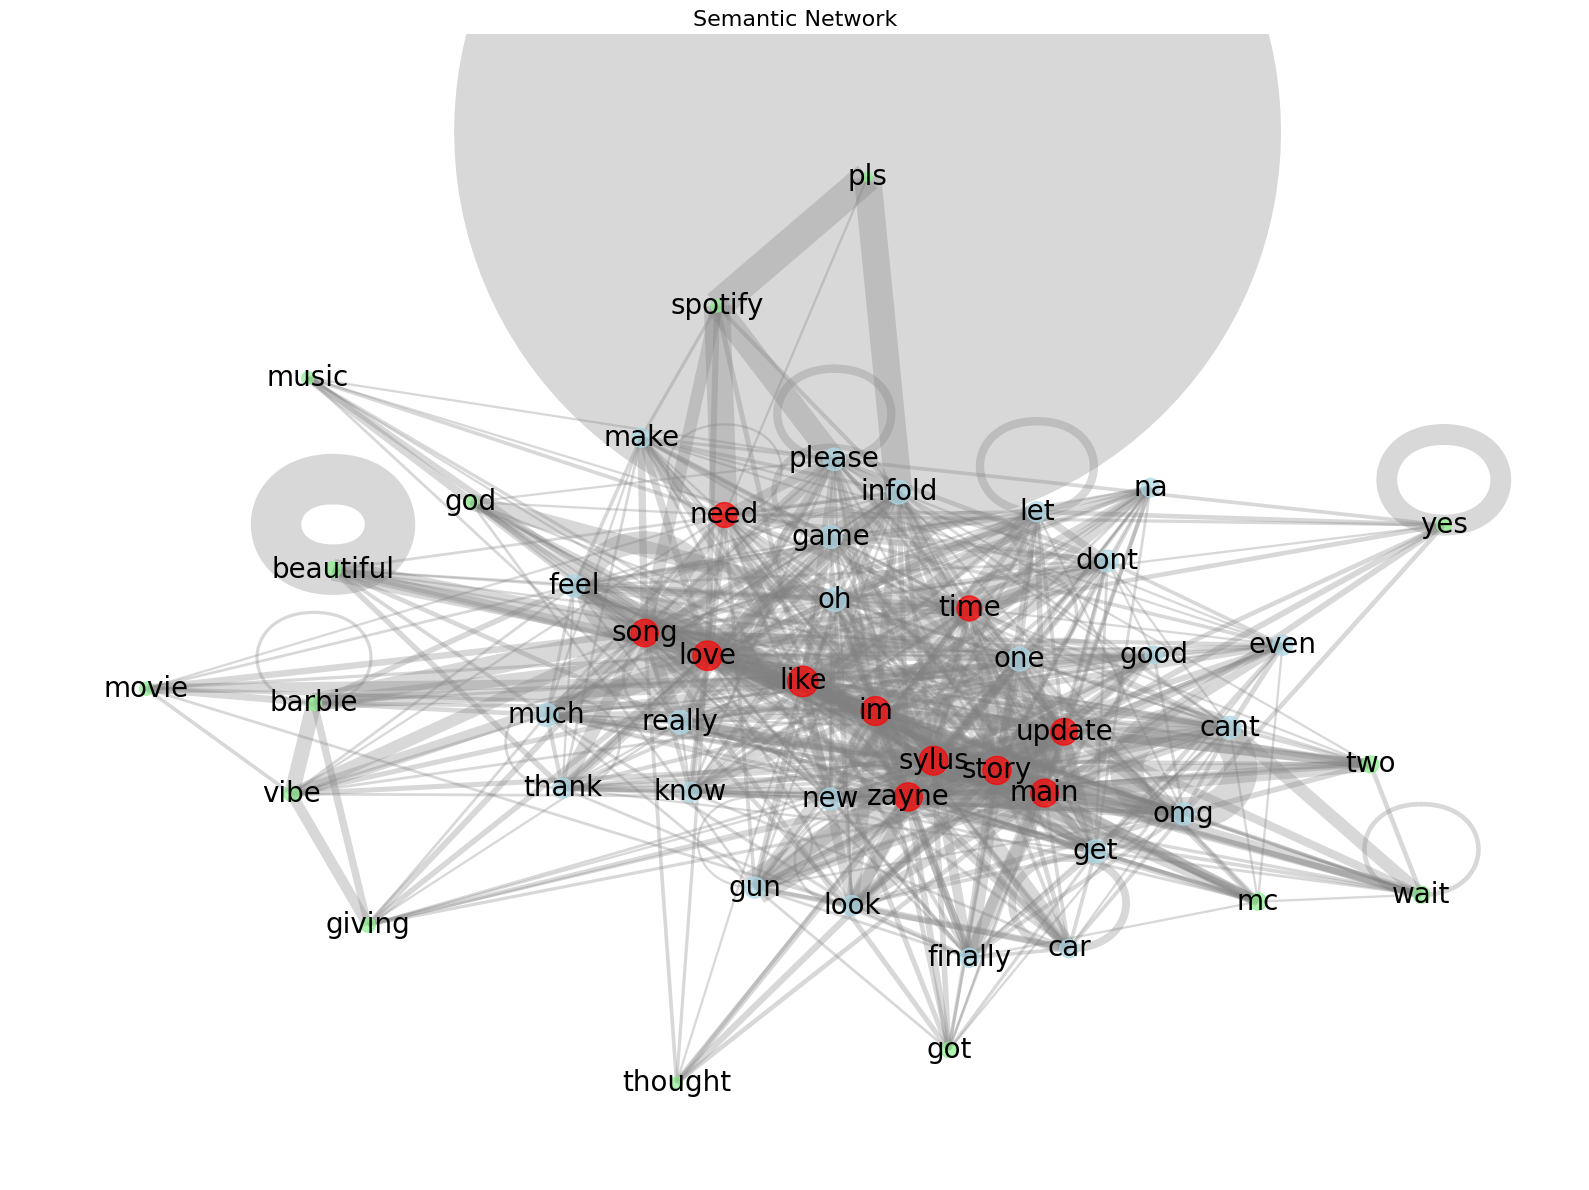

Top 10 nodes by degree (filtered):
like: 48
love: 45
sylus: 43
im: 43
zayne: 41
story: 41
main: 40
song: 39
update: 37
need: 32
Network density (filtered): 0.4776


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from datetime import datetime, timedelta
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string
import networkx as nx
import random
from matplotlib.colors import get_named_colors_mapping

# 下载必要的nltk数据
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

# 读取CSV文件
print("\nReading CSV files...")
try:
    file1_path = '/content/dataset_youtube-comments-scraper_2025-06-17_06-57-22-932.csv'
    df1 = pd.read_csv(file1_path)
    print(f"Successfully read {len(df1)} records from the first file")

    file2_path = '/content/dataset_youtube-comments-scraper_2025-06-17_07-02-35-990.csv'
    df2 = pd.read_csv(file2_path)
    print(f"Successfully read {len(df2)} records from the second file")

except FileNotFoundError as e:
    print(f"Error: File not found - {e.filename}")
    print("Please ensure the CSV file exists in the specified directory")
    exit()

# 合并数据集
print("\nMerging the two datasets...")
data = pd.concat([df1, df2], ignore_index=True)
print(f"Successfully merged {len(data)} records")

def preprocess_text(text):
    # 移除URL
    text = re.sub(r'http\S+', '', text)
    # 移除特殊字符和表情符号
    text = re.sub(r'[^\w\s]', '', text)
    # 转换为小写
    text = text.lower()
    # 过滤非英文字符
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # 分词
    tokens = word_tokenize(text)
    # 移除停用词
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    # 词形还原
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    # 移除单个字符
    tokens = [word for word in tokens if len(word) > 1]
    return ' '.join(tokens)

# 处理发布时间
def convert_time(text):
    now = datetime.now()
    if 'day' in text:
        days = int(re.search(r'\d+', text).group())
        return now - timedelta(days=days)
    elif 'week' in text:
        weeks = int(re.search(r'\d+', text).group())
        return now - timedelta(weeks=weeks)
    else:
        return now  # 默认返回当前时间

# 应用预处理
data['processed_comment'] = data['comment'].apply(preprocess_text)
data['date'] = data['publishedTimeText'].apply(convert_time)
data['week'] = data['date'].apply(lambda x: x.isocalendar()[1])  # 提取周数

# 构建语义网络
def build_semantic_network(text_series):
    G = nx.Graph()
    for comment in text_series:
        words = comment.split()
        for i in range(len(words)):
            for j in range(i + 1, len(words)):
                word1 = words[i]
                word2 = words[j]
                if G.has_edge(word1, word2):
                    G[word1][word2]['weight'] += 1
                else:
                    G.add_edge(word1, word2, weight=1)
    return G

# 统计词频并过滤低频词
from collections import Counter
word_freq = Counter()
for comment in data['processed_comment']:
    word_freq.update(comment.split())

MIN_FREQ = 40  # 词频阈值
filtered_comments = []
for comment in data['processed_comment']:
    words = comment.split()
    filtered_words = [word for word in words if word_freq[word] >= MIN_FREQ]
    filtered_comments.append(' '.join(filtered_words))

# 构建语义网络
semantic_network = build_semantic_network(filtered_comments)

# 过滤低频共现的边
MIN_EDGE_WEIGHT = 5  # 边权重阈值
edges_to_remove = [(u, v) for u, v, d in semantic_network.edges(data=True) if d['weight'] < MIN_EDGE_WEIGHT]
semantic_network.remove_edges_from(edges_to_remove)

# 过滤孤立节点
isolates = list(nx.isolates(semantic_network))
semantic_network.remove_nodes_from(isolates)

# 节点颜色与标签优化
all_nodes = list(semantic_network.nodes())
degree_dict = dict(semantic_network.degree())

# 节点颜色分配（按度数分组）
node_colors = []
for node in all_nodes:
    degree = degree_dict[node]
    if degree > np.percentile(list(degree_dict.values()), 75):
        node_colors.append('red')
    elif degree > np.percentile(list(degree_dict.values()), 25):
        node_colors.append('lightblue')
    else:
        node_colors.append('lightgreen')

all_node_labels = {node: node for node in all_nodes}

# ========== 关键修改：减小节点大小 ==========
plt.figure(figsize=(16, 12))
pos = nx.spring_layout(semantic_network, k=0.5, iterations=50)  # 调整布局参数

# 节点大小从 degree*20 减小到 degree*10
node_size = [degree_dict[node] * 10 for node in all_nodes]
# 边宽度调整（可选）
edge_width = [d['weight'] / 3 for (u, v, d) in semantic_network.edges(data=True)]

# 绘制节点（缩小尺寸+半透明）
nx.draw_networkx_nodes(semantic_network, pos, nodelist=all_nodes,
                       node_size=node_size, node_color=node_colors, alpha=0.7)
# 绘制边
nx.draw_networkx_edges(semantic_network, pos, width=edge_width,
                       edge_color='gray', alpha=0.3)
# 绘制标签（调整字体大小）
nx.draw_networkx_labels(semantic_network, pos, labels=all_node_labels,
                       font_size=20, font_color='black', font_family='Arial')

plt.title("Semantic Network", fontsize=16)
plt.axis('off')
plt.tight_layout()
plt.show()
# ==========================================

# 统计分析
print("Top 10 nodes by degree (filtered):")
sorted_degree = sorted(degree_dict.items(), key=lambda x: x[1], reverse=True)[:10]
for word, degree in sorted_degree:
    print(f"{word}: {degree}")

network_density = nx.density(semantic_network)
print(f"Network density (filtered): {network_density:.4f}")


# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# import re
# from datetime import datetime, timedelta
# from sklearn.feature_extraction.text import CountVectorizer
# from sklearn.decomposition import LatentDirichletAllocation
# from wordcloud import WordCloud
# import nltk
# from nltk.corpus import stopwords
# from nltk.tokenize import word_tokenize
# from nltk.stem import WordNetLemmatizer
# import string
# import networkx as nx
# import random
# from matplotlib.colors import LinearSegmentedColormap
# from sklearn.preprocessing import MinMaxScaler

# # 下载必要的nltk数据
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('punkt_tab')

# # 读取CSV文件
# print("\nReading CSV files...")
# try:
#     file1_path = '/content/dataset_youtube-comments-scraper_2025-06-17_06-57-22-932.csv'
#     df1 = pd.read_csv(file1_path)
#     print(f"Successfully read {len(df1)} records from the first file")

#     file2_path = '/content/dataset_youtube-comments-scraper_2025-06-17_07-02-35-990.csv'
#     df2 = pd.read_csv(file2_path)
#     print(f"Successfully read {len(df2)} records from the second file")

# except FileNotFoundError as e:
#     print(f"Error: File not found - {e.filename}")
#     print("Please ensure the CSV file exists in the specified directory")
#     exit()

# # 合并数据集
# print("\nMerging the two datasets...")
# data = pd.concat([df1, df2], ignore_index=True)
# print(f"Successfully merged {len(data)} records")

# def preprocess_text(text):
#     # 移除URL
#     text = re.sub(r'http\S+', '', text)
#     # 移除特殊字符和表情符号
#     text = re.sub(r'[^\w\s]', '', text)
#     # 转换为小写
#     text = text.lower()
#     # 过滤非英文字符
#     text = re.sub(r'[^a-zA-Z\s]', '', text)
#     # 分词
#     tokens = word_tokenize(text)
#     # 移除停用词
#     stop_words = set(stopwords.words('english'))
#     tokens = [word for word in tokens if word not in stop_words]
#     # 词形还原
#     lemmatizer = WordNetLemmatizer()
#     tokens = [lemmatizer.lemmatize(word) for word in tokens]
#     # 移除单个字符
#     tokens = [word for word in tokens if len(word) > 1]
#     return ' '.join(tokens)

# # 处理发布时间
# def convert_time(text):
#     now = datetime.now()
#     if 'day' in text:
#         days = int(re.search(r'\d+', text).group())
#         return now - timedelta(days=days)
#     elif 'week' in text:
#         weeks = int(re.search(r'\d+', text).group())
#         return now - timedelta(weeks=weeks)
#     else:
#         return now  # 默认返回当前时间

# # 应用预处理
# data['processed_comment'] = data['comment'].apply(preprocess_text)
# data['date'] = data['publishedTimeText'].apply(convert_time)
# data['week'] = data['date'].apply(lambda x: x.isocalendar()[1])  # 提取周数

# # 构建语义网络
# def build_semantic_network(text_series):
#     G = nx.Graph()
#     for comment in text_series:
#         words = comment.split()
#         for i in range(len(words)):
#             for j in range(i + 1, len(words)):
#                 word1 = words[i]
#                 word2 = words[j]
#                 if G.has_edge(word1, word2):
#                     G[word1][word2]['weight'] += 1
#                 else:
#                     G.add_edge(word1, word2, weight=1)
#     return G

# # 统计词频并过滤低频词
# from collections import Counter
# word_freq = Counter()
# for comment in data['processed_comment']:
#     word_freq.update(comment.split())

# MIN_FREQ = 40  # 词频阈值
# filtered_comments = []
# for comment in data['processed_comment']:
#     words = comment.split()
#     filtered_words = [word for word in words if word_freq[word] >= MIN_FREQ]
#     filtered_comments.append(' '.join(filtered_words))

# # 构建语义网络
# semantic_network = build_semantic_network(filtered_comments)

# # 过滤低频共现的边
# MIN_EDGE_WEIGHT = 5  # 边权重阈值
# edges_to_remove = [(u, v) for u, v, d in semantic_network.edges(data=True) if d['weight'] < MIN_EDGE_WEIGHT]
# semantic_network.remove_edges_from(edges_to_remove)

# # 过滤孤立节点
# isolates = list(nx.isolates(semantic_network))
# semantic_network.remove_nodes_from(isolates)

# # 节点颜色与标签优化
# all_nodes = list(semantic_network.nodes())
# degree_dict = dict(semantic_network.degree())

# # 节点颜色分配（按度数分组）
# node_colors = []
# for node in all_nodes:
#     degree = degree_dict[node]
#     if degree > np.percentile(list(degree_dict.values()), 75):
#         node_colors.append('red')
#     elif degree > np.percentile(list(degree_dict.values()), 25):
#         node_colors.append('lightblue')
#     else:
#         node_colors.append('lightgreen')

# all_node_labels = {node: node for node in all_nodes}

# # ========== 关键修改：边颜色渐变 ==========
# # 提取边的权重
# edge_weights = [d['weight'] for u, v, d in semantic_network.edges(data=True)]

# # 归一化边的权重（0-1）
# scaler = MinMaxScaler()
# normalized_weights = scaler.fit_transform(np.array(edge_weights).reshape(-1, 1))

# # 创建颜色渐变（从浅灰色到深灰色）
# cmap = LinearSegmentedColormap.from_list(
#     'edge_cmap',
#     ['#D3D3D3', '#333333'],  # 浅灰色到深灰色
#     N=256
# )

# # 根据归一化的权重映射颜色
# edge_colors = [cmap(w[0]) for w in normalized_weights]

# # 调整布局参数
# plt.figure(figsize=(16, 12))
# pos = nx.spring_layout(semantic_network, k=0.5, iterations=50)  # 调整布局参数

# # 节点大小从 degree*20 减小到 degree*10
# node_size = [degree_dict[node] * 10 for node in all_nodes]
# # 边宽度调整
# edge_width = [d['weight'] / 3 for (u, v, d) in semantic_network.edges(data=True)]

# # 绘制节点（缩小尺寸+半透明）
# nx.draw_networkx_nodes(semantic_network, pos, nodelist=all_nodes,
#                        node_size=node_size, node_color=node_colors, alpha=0.7)
# # 绘制边（颜色渐变）
# nx.draw_networkx_edges(semantic_network, pos, width=edge_width,
#                        edge_color=edge_colors, alpha=0.7)  # 调整边的透明度
# # 绘制标签（调整字体大小，放大文字）
# nx.draw_networkx_labels(semantic_network, pos, labels=all_node_labels,
#                        font_size=20,
#                        font_color='black',
#                        font_family='Arial')

# plt.title("Semantic Network", fontsize=16)
# plt.axis('off')
# plt.tight_layout()
# plt.show()
# # ==========================================

# # 统计分析
# print("Top 10 nodes by degree (filtered):")
# sorted_degree = sorted(degree_dict.items(), key=lambda x: x[1], reverse=True)[:10]
# for word, degree in sorted_degree:
#     print(f"{word}: {degree}")

# network_density = nx.density(semantic_network)
# print(f"Network density (filtered): {network_density:.4f}")